# Understanding the local electricity market

## 📖 Background
You work for an energy company in Australia. Your company builds solar panel arrays and then sells the energy they produce to industrial customers. The company wants to expand to the city of Melbourne in the state of Victoria. 

Prices and demand for electricity change every day. Customers pay for the energy received using a formula based on the local energy market's daily price.



## 💾 The data
You have access to over five years of energy price and demand data:

- "date" - from January 1, 2015, to October 6, 2020.
- "demand" - daily electricity demand in MWh.
- "price" - recommended retail price in AUD/MWh.
- "demand_pos_price" - total daily demand at a positive price in MWh.
- "price_positive" - average positive price, weighted by the corresponding intraday demand in AUD/MWh.
- "demand_neg_price" - total daily demand at a negative price in MWh.
- "price_negative" - average negative price, weighted by the corresponding intraday demand in AUD/MWh.
- "frac_neg_price" - the fraction of the day when the demand traded at a negative price.
- "min_temperature" - minimum temperature during the day in Celsius.
- "max_temperature" - maximum temperature during the day in Celsius.
- "solar_exposure" - total daily sunlight energy in MJ/m^2.
- "rainfall" - daily rainfall in mm.
- "school_day" - "Y" if that day was a school day, "N" otherwise.
- "holiday" - "Y" if the day was a state or national holiday, "N" otherwise.

Note: The price was negative during some intraday intervals, so energy producers were paying buyers rather than vice-versa.

In [166]:
#Loading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [167]:
#Loading file with data and display first 5 rows
df = pd.read_csv('./data/energy_demand.csv', parse_dates=['date'])
df.head(5)

,date,demand,price,demand_pos_price,price_positive,demand_neg_price,price_negative,frac_neg_price,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
0,2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,N,Y
1,2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,N,N
2,2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,N,N
3,2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,N,N
4,2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,N,N


In [168]:
#General information about data
df_info = df.info()
display(df_info)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2106 entries, 0 to 2105
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              2106 non-null   datetime64[ns]
 1   demand            2106 non-null   float64       
 2   price             2106 non-null   float64       
 3   demand_pos_price  2106 non-null   float64       
 4   price_positive    2106 non-null   float64       
 5   demand_neg_price  2106 non-null   float64       
 6   price_negative    2106 non-null   float64       
 7   frac_neg_price    2106 non-null   float64       
 8   min_temperature   2106 non-null   float64       
 9   max_temperature   2106 non-null   float64       
 10  solar_exposure    2105 non-null   float64       
 11  rainfall          2103 non-null   float64       
 12  school_day        2106 non-null   object        
 13  holiday           2106 non-null   object        
dtypes: datetime64[ns](1), fl

None

In [169]:
#Statistical information 
df_with_float = df.drop(['date', 'school_day', 'holiday'], axis = 1)
df_with_float.describe()

,demand,price,demand_pos_price,price_positive,demand_neg_price,price_negative,frac_neg_price,min_temperature,max_temperature,solar_exposure,rainfall
count,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2106.000000,2105.000000,2103.000000
mean,120035.476503,76.079554,119252.305055,76.553847,783.171448,-2.686052,0.008547,11.582289,20.413200,14.743373,1.505944
std,13747.993761,130.246805,14818.631319,130.114184,3578.920686,19.485432,0.039963,4.313711,6.288693,7.945527,4.307897
min,85094.375000,-6.076028,41988.240000,13.568986,0.000000,-342.220000,0.000000,0.600000,9.000000,0.700000,0.000000
25%,109963.650000,38.707040,109246.250000,39.117361,0.000000,0.000000,0.000000,8.500000,15.525000,8.200000,0.000000
50%,119585.912500,66.596738,119148.082500,66.869058,0.000000,0.000000,0.000000,11.300000,19.100000,12.700000,0.000000
75%,130436.006250,95.075012,130119.477500,95.130181,0.000000,0.000000,0.000000,14.600000,23.900000,20.700000,0.800000
max,170653.840000,4549.645105,170653.840000,4549.645105,57597.595000,0.000000,0.625000,28.000000,43.500000,33.300000,54.600000


<AxesSubplot:>

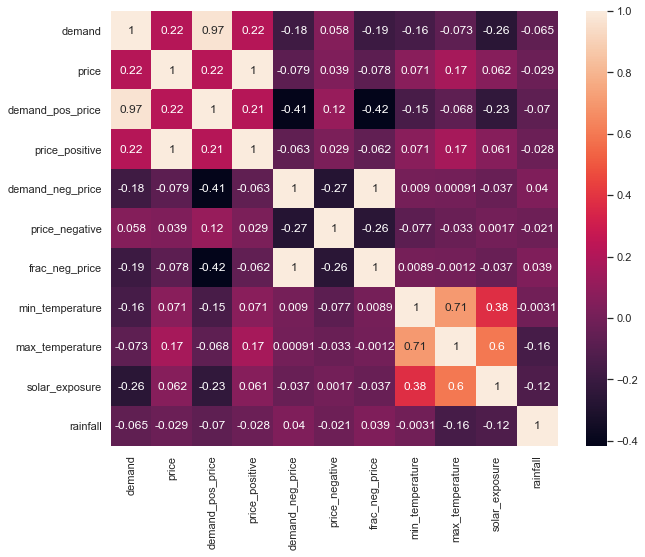

In [170]:
#Visualization of correlation between columns
df_corr = df_with_float.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(data = df_corr, annot = True)

<Figure size 720x576 with 0 Axes>

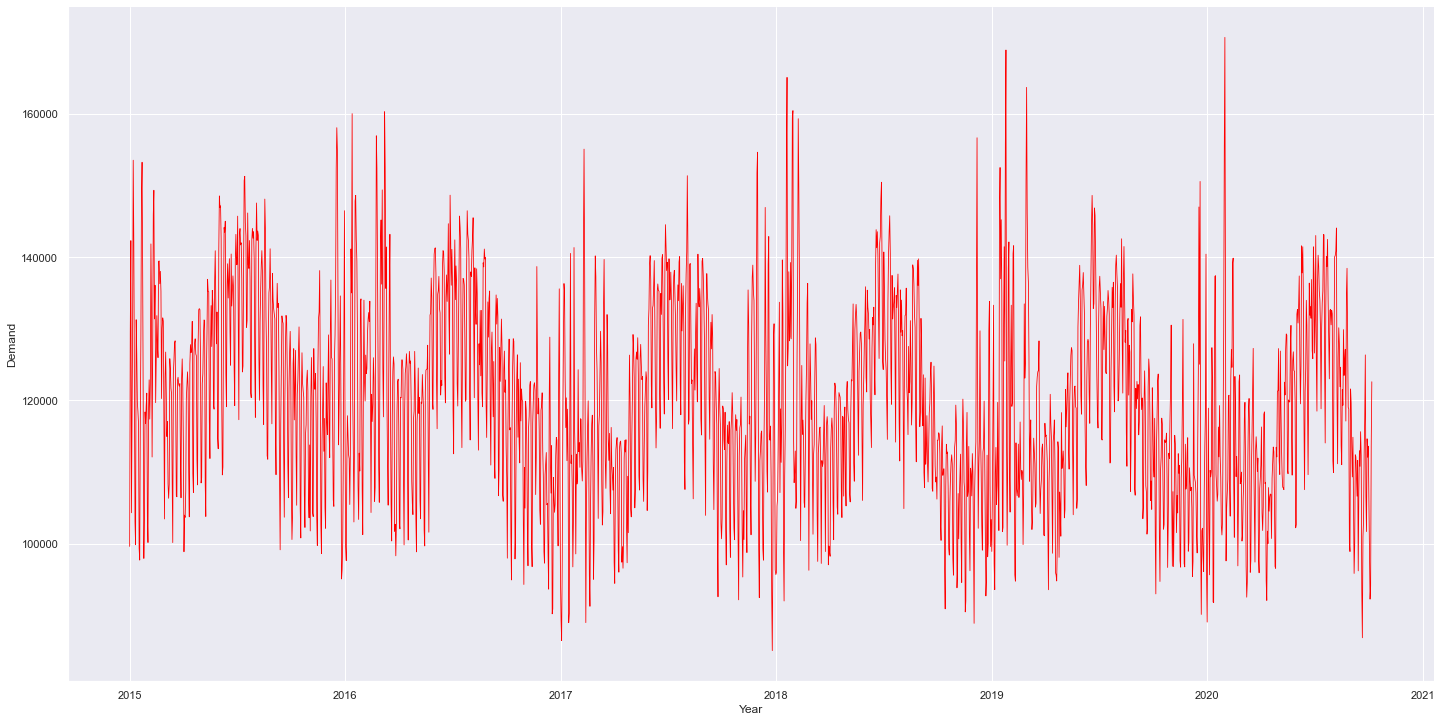

<Figure size 720x576 with 0 Axes>

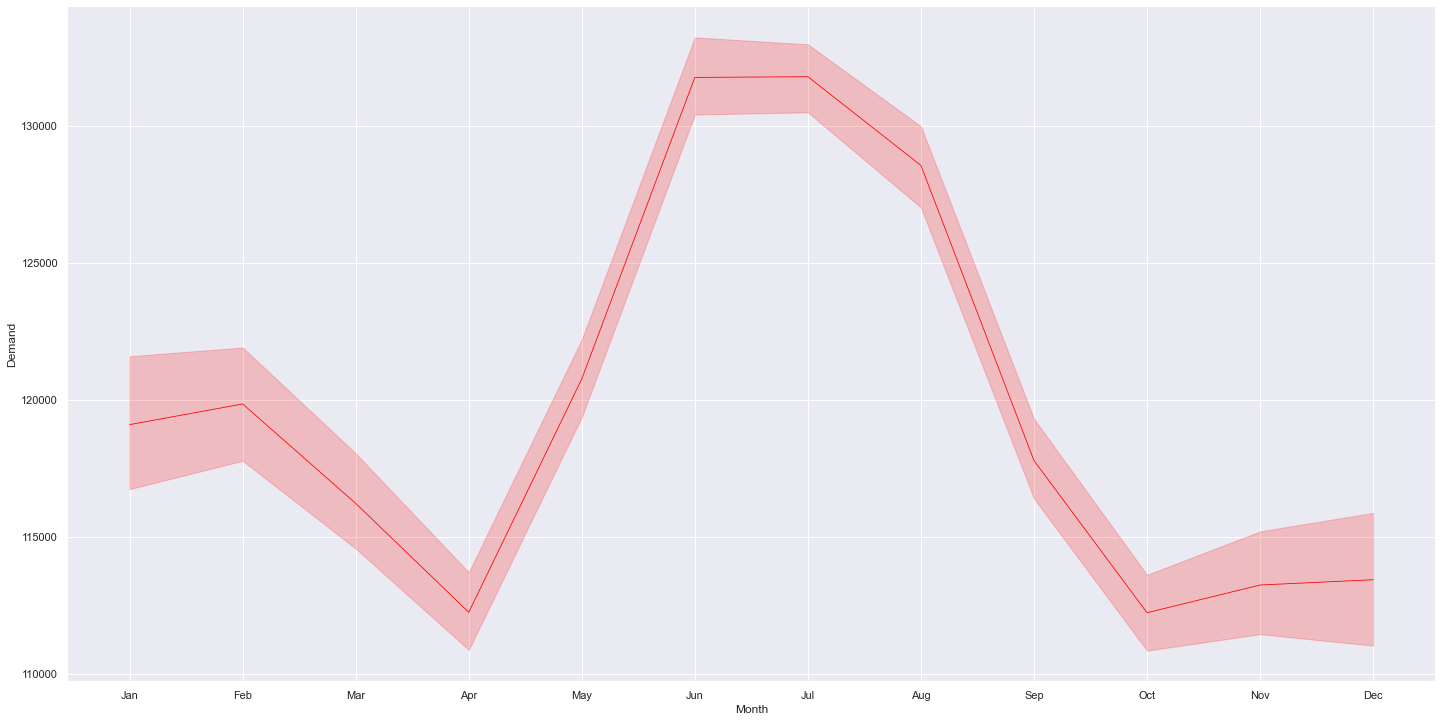

<Figure size 720x576 with 0 Axes>

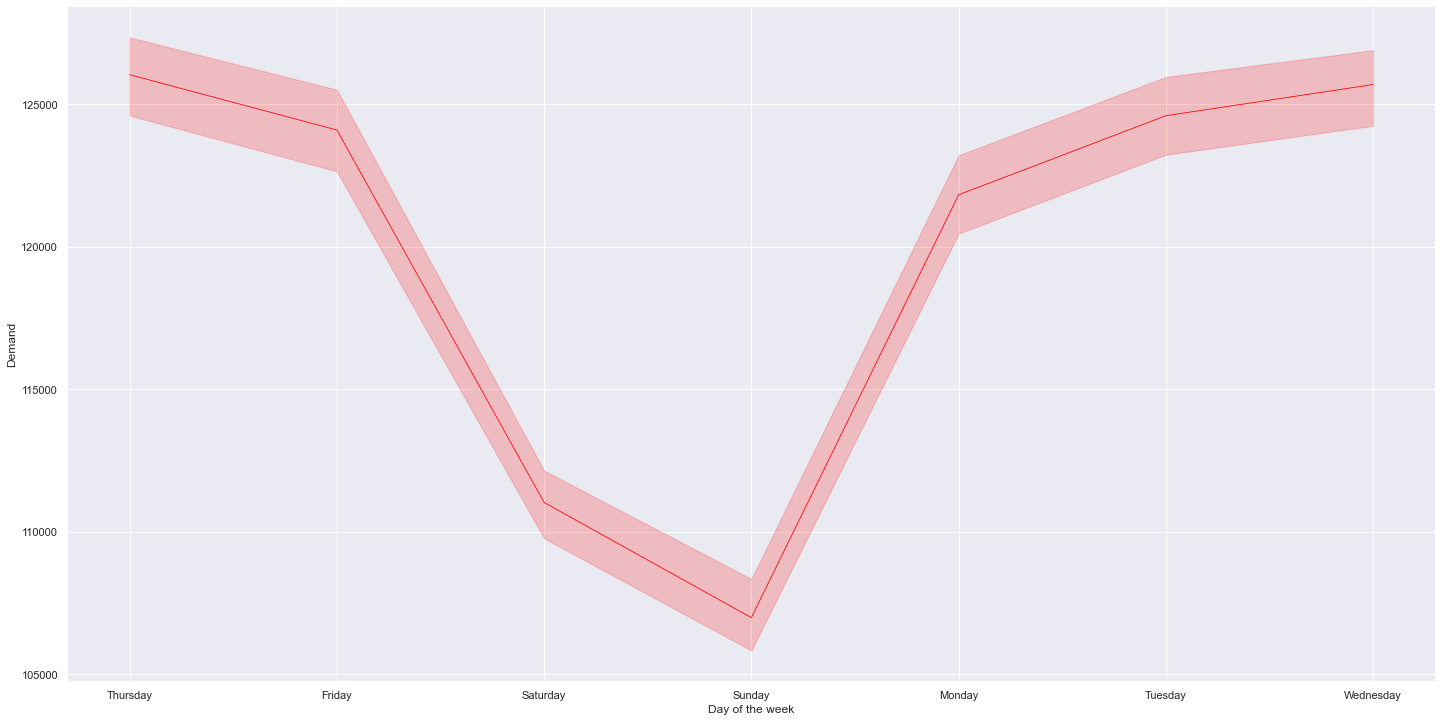

In [171]:
#Visualization of the relationship between date(year, month) and demand
plt.figure(figsize=(10, 8))
sns.set_theme(style = 'darkgrid')
fig = sns.relplot(
    x = 'date', y = 'demand', kind = 'line', 
    data = df, height = 10, aspect = 2, 
    linewidth = 0.8, color = 'red'
)
fig.set(xlabel = 'Year', ylabel = 'Demand')

df['date_month'] = df['date'].dt.strftime('%b')
df['date_year'] = df['date'].dt.year
df['date_day'] = df['date'].dt.strftime('%A')

plt.figure(figsize=(10, 8))
fig = sns.relplot(
    x = 'date_month', y = 'demand', 
    kind = 'line', data=df, height=10, aspect=2, 
    linewidth = 0.8, color = 'red'
)
fig.set(xlabel = 'Month', ylabel = 'Demand')

plt.figure(figsize=(10, 8))
fig = sns.relplot(
    x = 'date_day', y = 'demand', 
    kind = 'line', data=df, height=10, aspect=2, 
    linewidth = 0.8, color = 'red'
)
fig.set(xlabel = 'Day of the week', ylabel = 'Demand')

<Figure size 720x576 with 0 Axes>

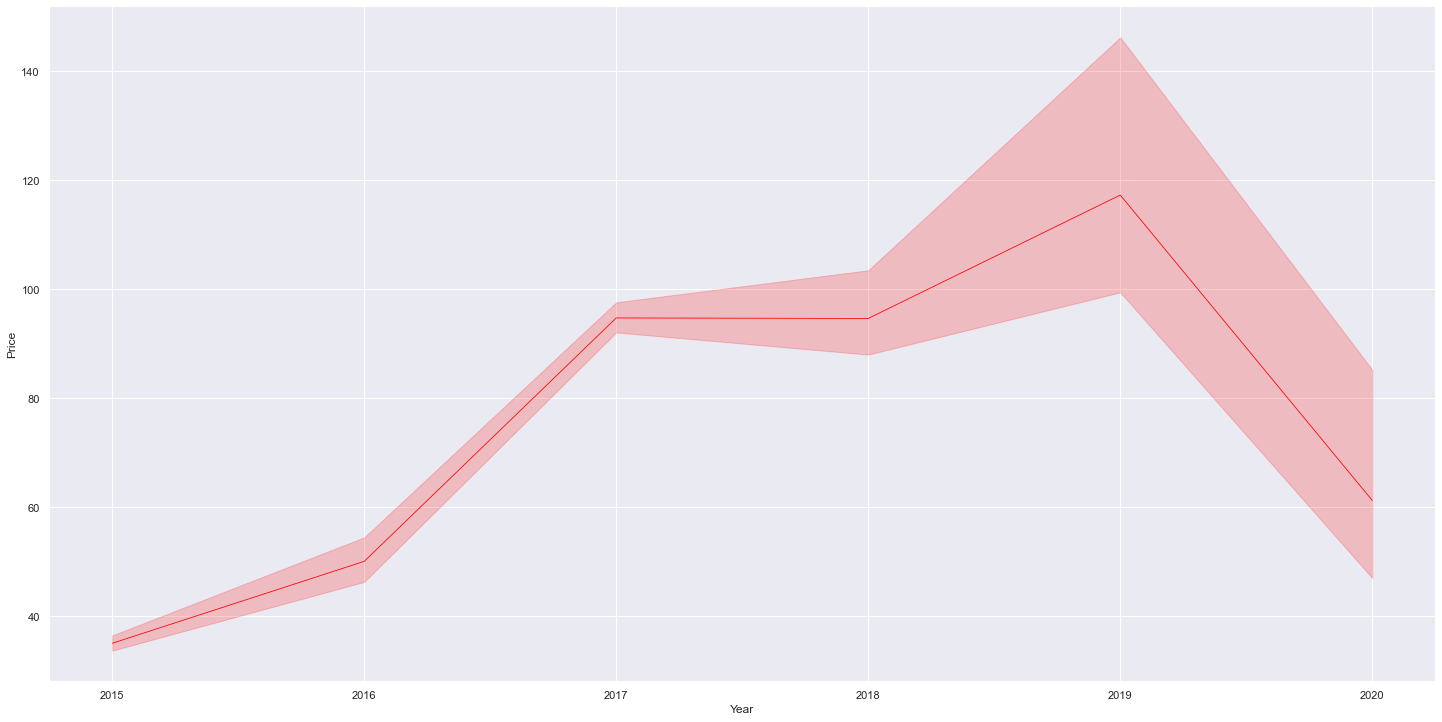

<Figure size 720x576 with 0 Axes>

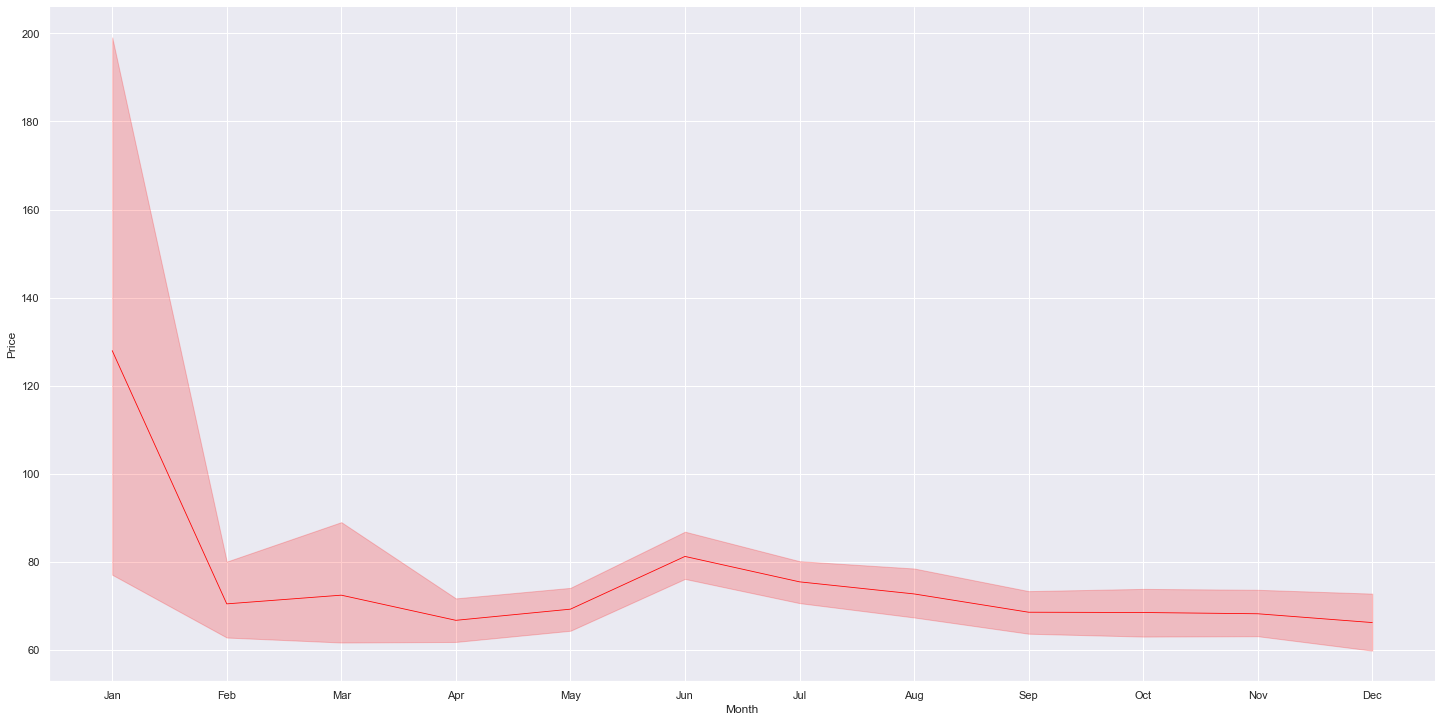

<Figure size 720x576 with 0 Axes>

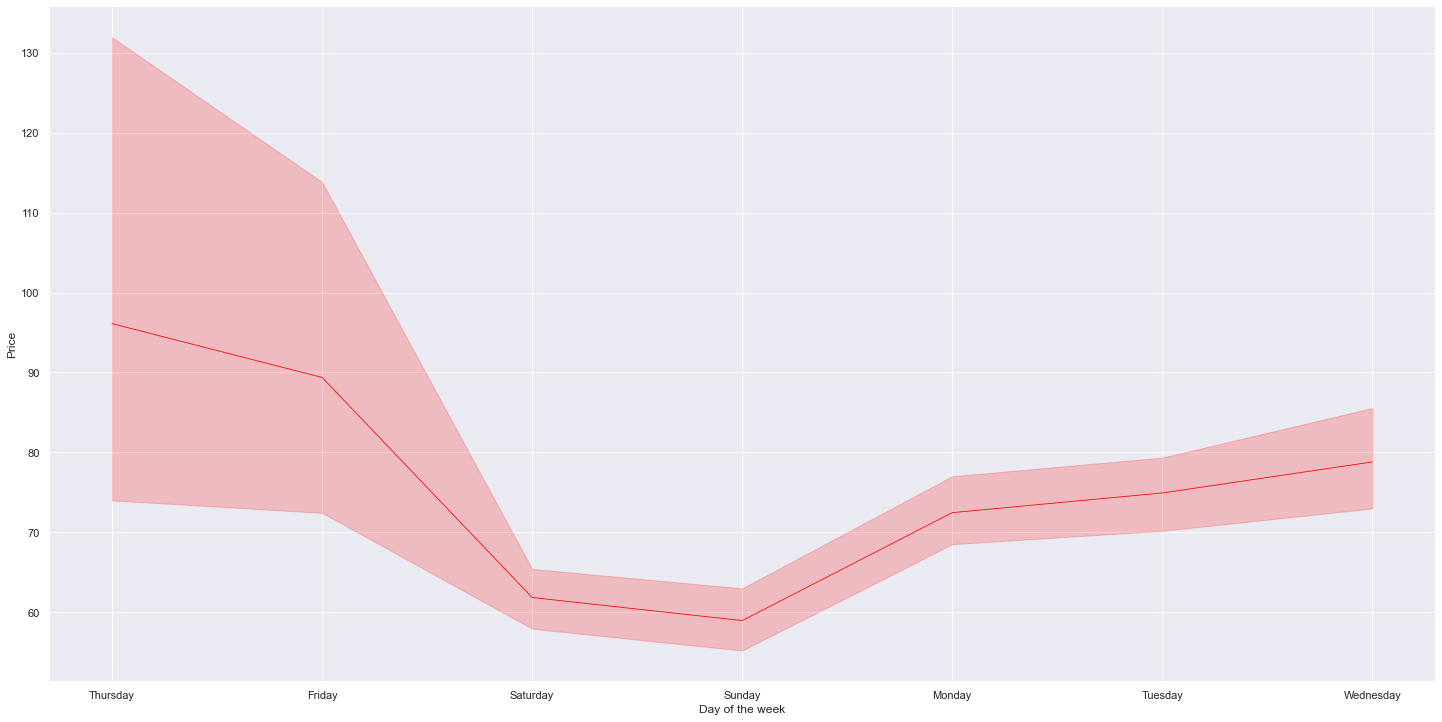

In [172]:
#Visualization of the relationship between date(year, month) and price
plt.figure(figsize=(10, 8))
sns.set_theme(style="darkgrid")
fig = sns.relplot(
    x = 'date_year', y = 'price', 
    kind = 'line', data=df, height=10, aspect=2, 
    linewidth = 0.8, color = 'red'
)
fig.set(xlabel = 'Year', ylabel = 'Price')

plt.figure(figsize=(10, 8))
sns.set_theme(style="darkgrid")
fig = sns.relplot(
    x = 'date_month', y = 'price', 
    kind = 'line', data=df, height=10, aspect=2, 
    linewidth = 0.8, color = 'red'
)
fig.set(xlabel = 'Month', ylabel = 'Price')

plt.figure(figsize=(10, 8))
sns.set_theme(style="darkgrid")
fig = sns.relplot(
    x = 'date_day', y = 'price', 
    kind = 'line', data=df, height=10, aspect=2, 
    linewidth = 0.8, color = 'red'
)
fig.set(xlabel = 'Day of the week', ylabel = 'Price')

<Figure size 720x576 with 0 Axes>

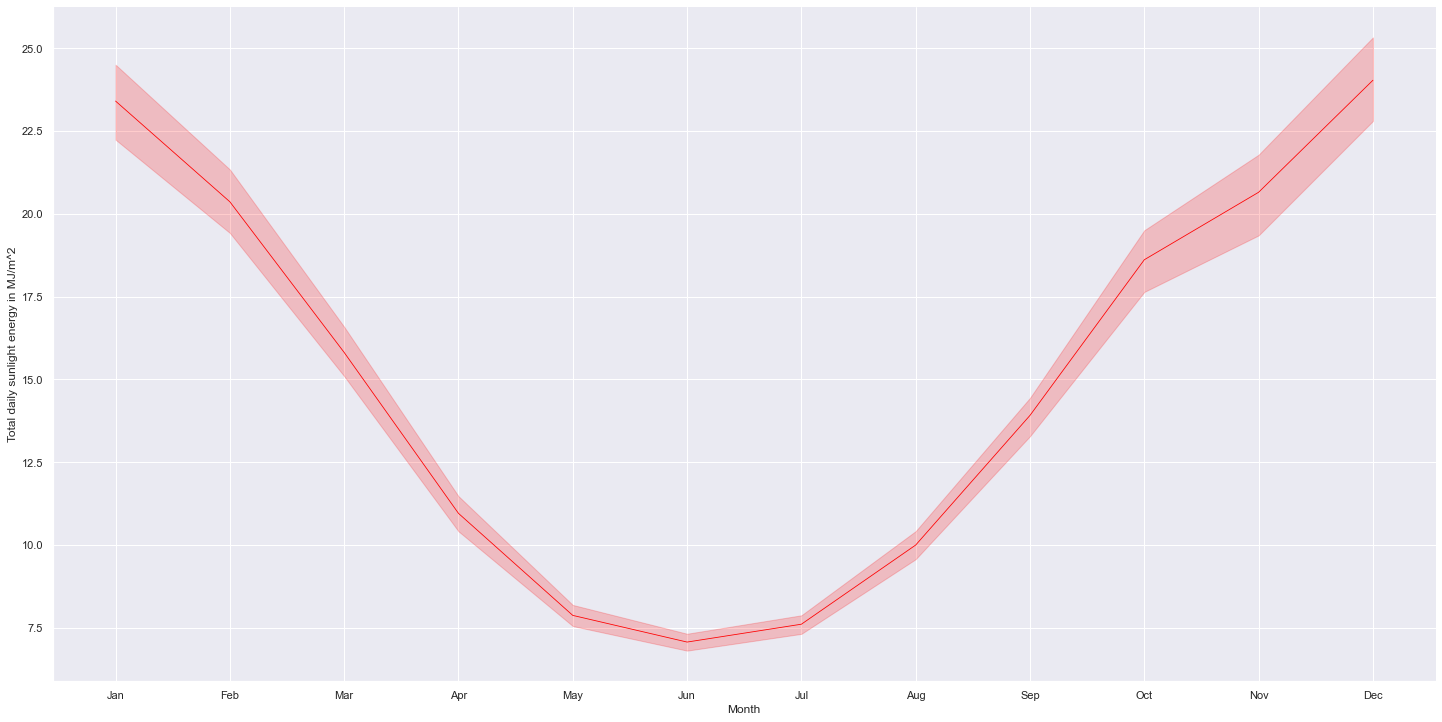

In [173]:
#Visualization of the relationship between date(month) and total daily sunlight energy in MJ/m^2
plt.figure(figsize=(10, 8))
sns.set_theme(style="darkgrid")
fig = sns.relplot(
    x = df['date_month'], y = 'solar_exposure', 
    kind = 'line', data = df, height=10, aspect=2, 
    linewidth = 0.8, color = 'red'
)
fig.set(xlabel = 'Month', ylabel = 'Total daily sunlight energy in MJ/m^2')

[Text(0.5, 0, 'Holiday day'), Text(0, 0.5, 'Price')]

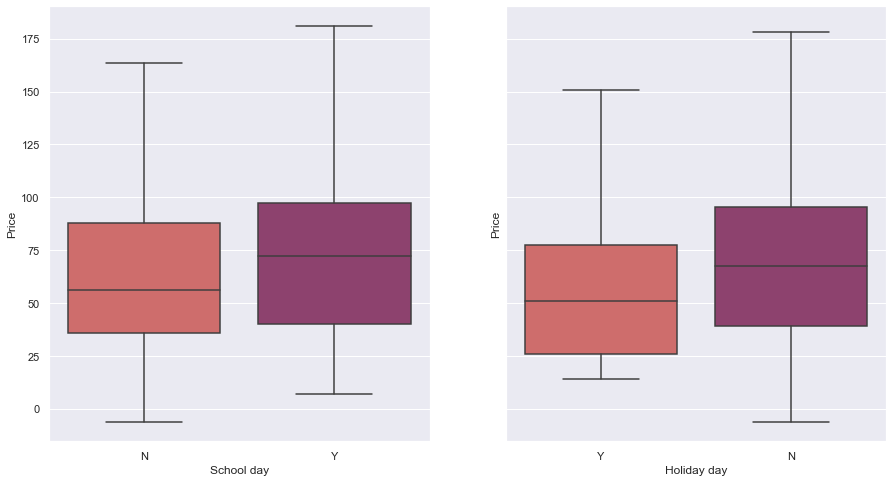

In [174]:
#Visualization how school day and holiday impact on the price
fig, axes = plt.subplots(1, 2, figsize = (15, 8), sharey = True)

fig = sns.boxplot(
    x = 'school_day', y = 'price', 
    data = df, showfliers = False, 
    ax = axes[0], palette = 'flare'
)
fig.set(xlabel = 'School day', ylabel = 'Price')

fig = sns.boxplot(
    x = 'holiday', y = 'price', 
    data = df, showfliers = False, 
    ax = axes[1], palette = 'flare'
)
fig.set(xlabel = 'Holiday day', ylabel = 'Price')

[Text(0.5, 0, 'Maximum temperature during the day in Celsius'),
 Text(0, 0.5, 'Density')]

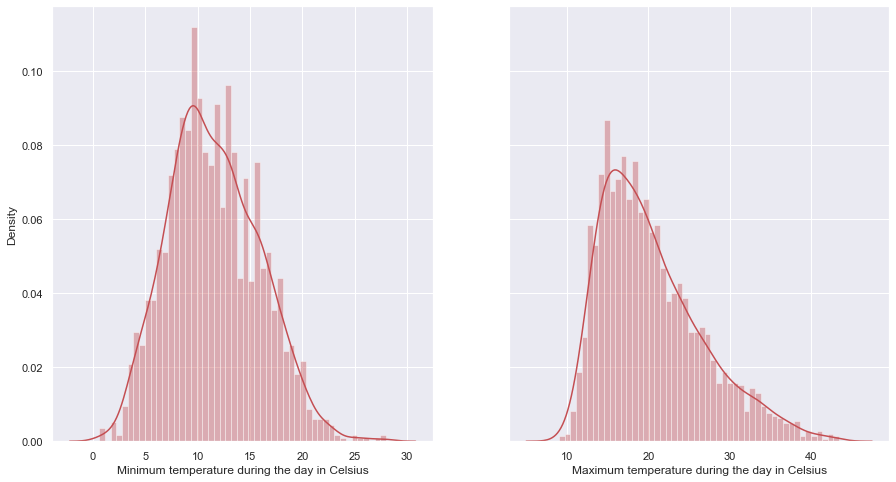

In [175]:
#Visualization of distribution for temperatures
fig, axes = plt.subplots(1, 2, figsize = (15, 8), sharey = True)

fig = sns.distplot(
    x = df['min_temperature'], 
    bins = 50, 
    color = 'r',
    ax = axes[0]
)
fig.set(xlabel = 'Minimum temperature during the day in Celsius', 
        ylabel = 'Density')

fig = sns.distplot(
    x = df['max_temperature'], 
    bins = 50, 
    color = 'r',
    ax = axes[1]
)
fig.set(xlabel = 'Maximum temperature during the day in Celsius', 
        ylabel = 'Density')

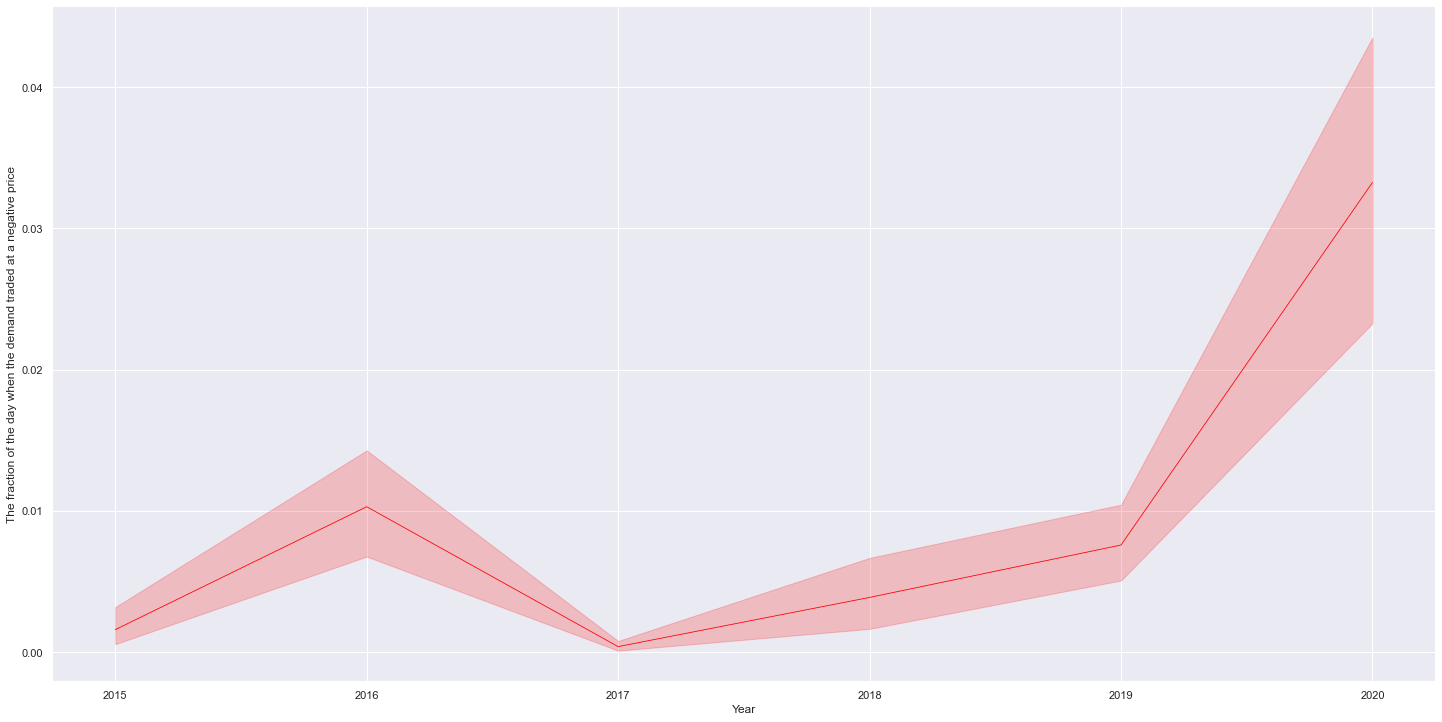

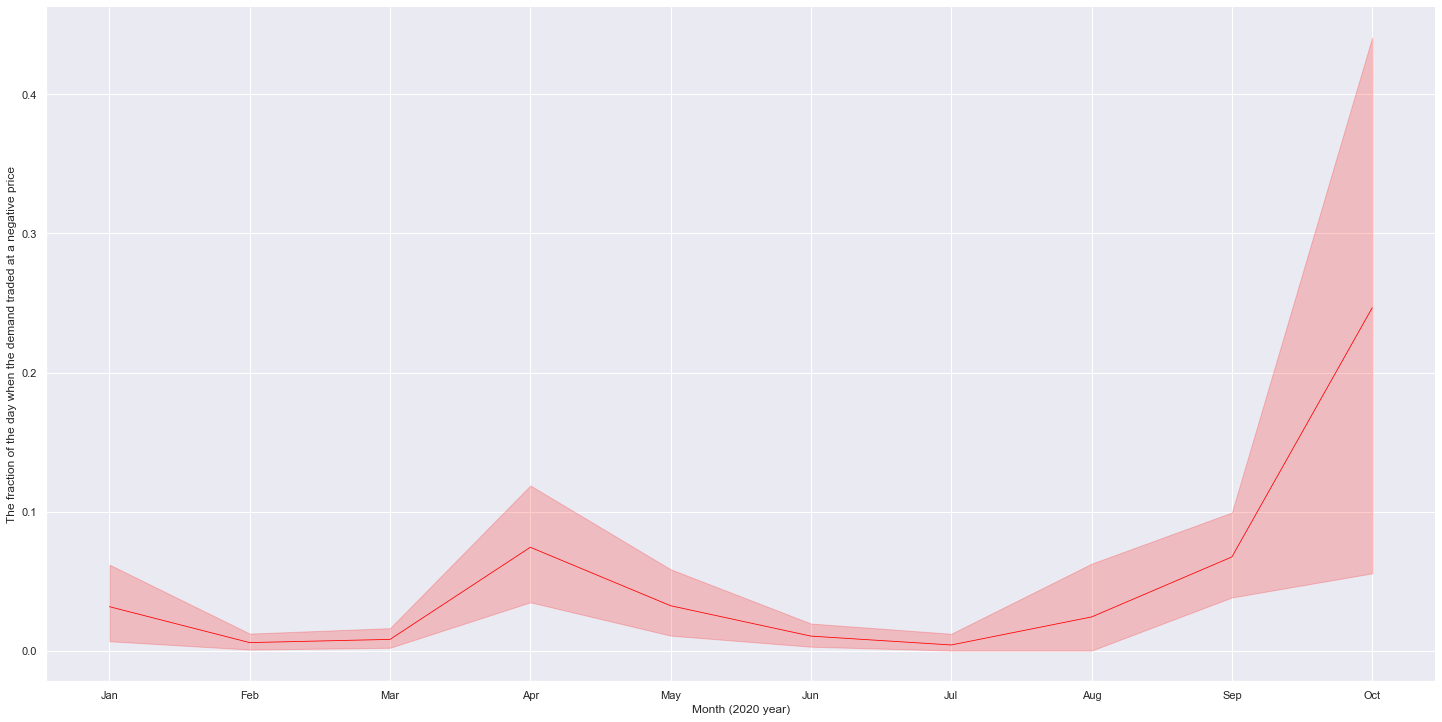

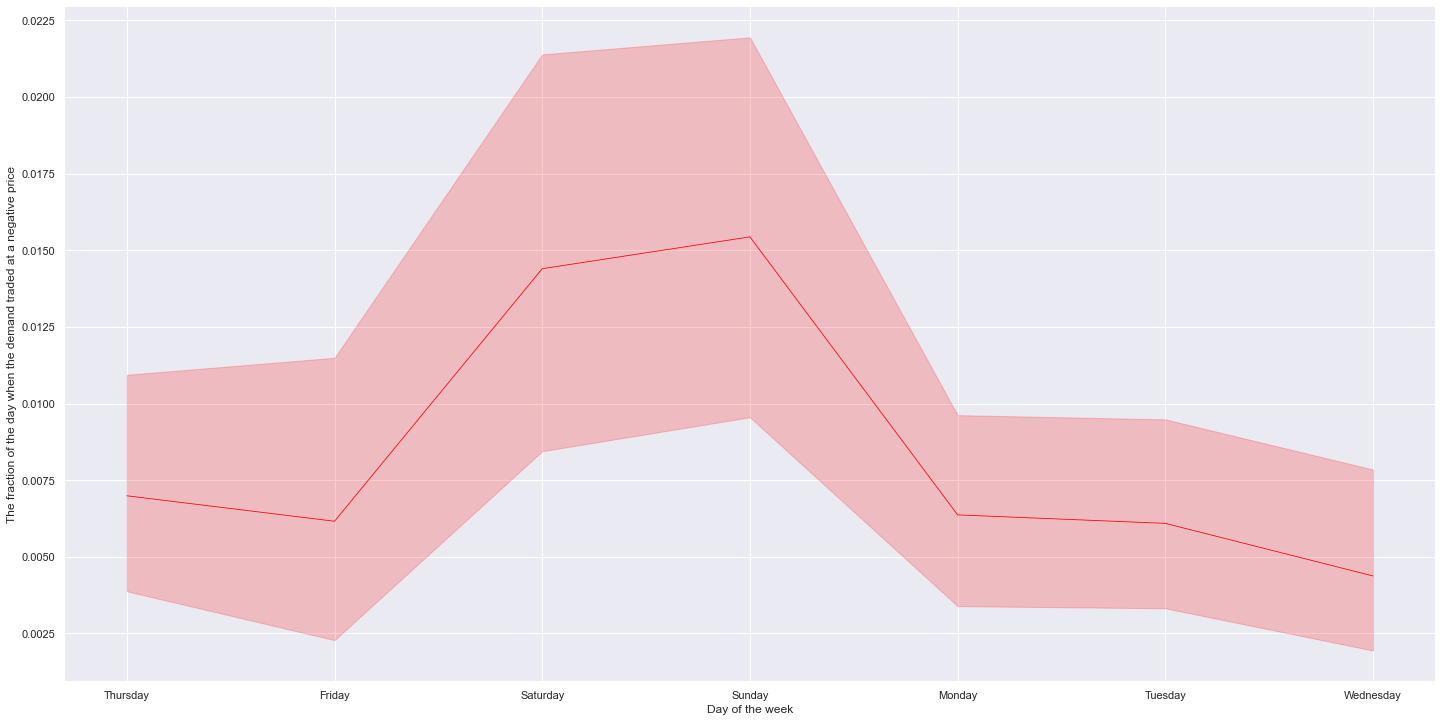

In [176]:
#Visualization of the fraction of the day when the demand traded at a negative price with years, months
df_for_frac = df[df['date_year'] == 2020]

fig = sns.relplot(
    x = 'date_year', y = 'frac_neg_price', kind = 'line', 
    data = df, height = 10, aspect = 2, 
    linewidth = 0.8, color = 'red'
)
fig.set(xlabel = 'Year', 
        ylabel = 'The fraction of the day when the demand traded at a negative price')


fig = sns.relplot(
    x = 'date_month', y = 'frac_neg_price', kind = 'line', 
    data = df_for_frac, height = 10, aspect = 2, 
    linewidth = 0.8, color = 'red'
)
fig.set(xlabel = 'Month (2020 year)', 
        ylabel = 'The fraction of the day when the demand traded at a negative price')

fig = sns.relplot(
    x = 'date_day', y = 'frac_neg_price', kind = 'line', 
    data = df, height = 10, aspect = 2, 
    linewidth = 0.8, color = 'red'
)
fig.set(xlabel = 'Day of the week', 
        ylabel = 'The fraction of the day when the demand traded at a negative price')

In [177]:
#Avarage values of important columns by years
df.groupby('date_year')[['price', 'demand', 'frac_neg_price']].mean()

,price,demand,frac_neg_price
date_year,,,
2015,35.068136,124662.169877,0.001598
2016,50.094252,121989.538757,0.010303
2017,94.740161,118953.048685,0.000400
2018,94.648823,118810.565233,0.003881
2019,117.281370,117939.613397,0.007591
2020,61.266055,117189.901268,0.033259


In [178]:
#Avarage values of important columns by months
df.groupby(['date_month'])[['price', 'demand', 'frac_neg_price', 'solar_exposure']].mean()

,price,demand,frac_neg_price,solar_exposure
date_month,,,,
Apr,66.740784,112245.103556,0.016088,10.949444
Aug,72.732320,128559.799140,0.011985,9.993011
Dec,66.229981,113432.891581,0.007527,24.032903
Feb,70.476061,119850.617706,0.003309,20.361176
Jan,127.970679,119096.530054,0.006048,23.403763
Jul,75.476441,131799.381022,0.003584,7.601075
Jun,81.245597,131773.203694,0.002431,7.061667
Mar,72.450579,116220.643871,0.001792,15.810215
May,69.272424,120767.550995,0.010865,7.867204


In [179]:
#Avarage values of important columns by days of the week
df.groupby(['date_day'])[['price', 'demand', 'frac_neg_price']].mean()

,price,demand,frac_neg_price
date_day,,,
Friday,89.377332,124098.625017,0.006160
Monday,72.477842,121825.294601,0.006368
Saturday,61.867345,111023.493189,0.014396
Sunday,58.983380,106980.556678,0.015435
Thursday,96.106250,126041.761628,0.006991
Tuesday,74.938984,124601.643140,0.006091
Wednesday,78.814831,125695.766217,0.004375


In [180]:
#Working with categorical data
cat_cols = ['school_day', 'holiday', 'date_month', 'date_day']
df[cat_cols] = df[cat_cols].astype('category')
label_encoder = LabelEncoder()
for column_name in df:
    if df[column_name].dtype.name == 'category':
        df[column_name] = label_encoder.fit_transform(df[column_name])

In [181]:
#Modeling of data
X = df.drop(['date', 'price'], axis = 1)
y = df['price']
X = X.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [182]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, random_state = 42) 

In [183]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared = False)
print('RMSE:', rmse)

RMSE: 1.359144383189296
